In [1]:
import warnings
warnings.filterwarnings("ignore")

from utils import datasets, model_utils, tscp, metrics
from utils.cpd_models import fix_seeds

from utils.ensembles import EnsembleCPDModel, CusumEnsembleCPDModel
from utils.visualize import visualize_predictions

import yaml

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from datetime import datetime
from time import time

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

%load_ext autoreload
%autoreload

%matplotlib inline

# Visualize predictions, single model

In [2]:
model_type = "tscp"

experiments_name = "yahoo"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 4

# set args_config["learning"]["gpus"] = 0 for training models on CPU
#args_config["learning"]["gpus"] = 1
args_config["learning"]["accelerator"] = 'cpu'
args_config["learning"]["devices"] = 1

train_dataset, test_dataset = datasets.CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False)

seq_batch, labels_batch = next(iter(test_dataloader))

In [3]:
model_num = 1

fix_seeds(model_num)

tscp_model_yahoo = model_utils.get_tscp_models_list(args_config, train_dataset, test_dataset)[0]

seq_len = len(train_dataset[0][0])

# use logger
model_name = f'tscp_model_seq_{seq_len}_window_{args_config["model"]["window"]}_model_num_{model_num}'
save_path = f"temp_saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}/{model_name}.pth"

tscp_model_yahoo.load_state_dict(torch.load(save_path));

In [4]:
raw_scores = tscp.get_tscp_output_padded(
    tscp_model_yahoo,
    seq_batch,
    window_1=args_config["model"]["window_1"],
    window_2=args_config["model"]["window_2"],
    step=args_config["predictions"]["step"],
)

preds = tscp.post_process_tscp_output(raw_scores, alpha=args_config["predictions"]["alpha"])

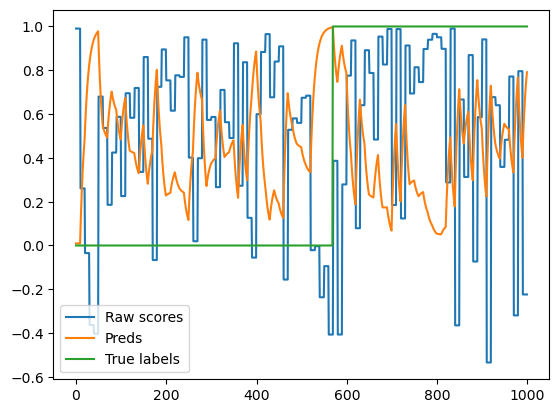

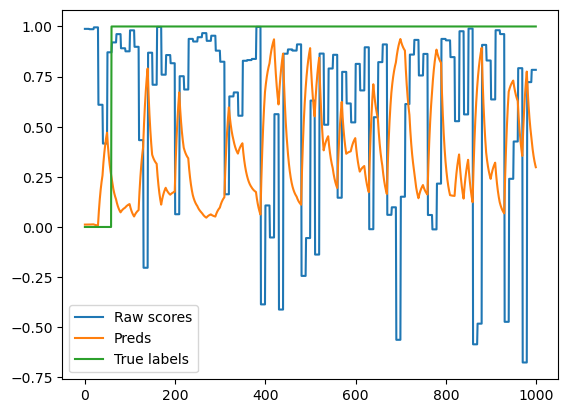

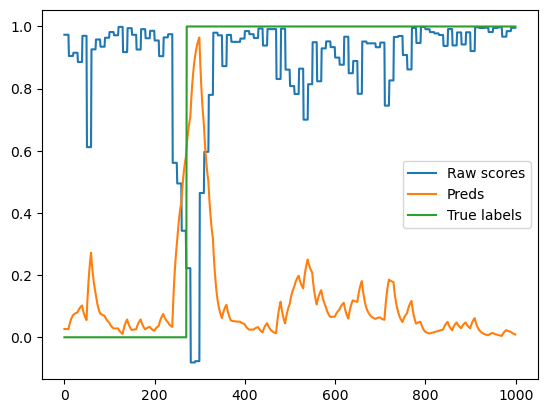

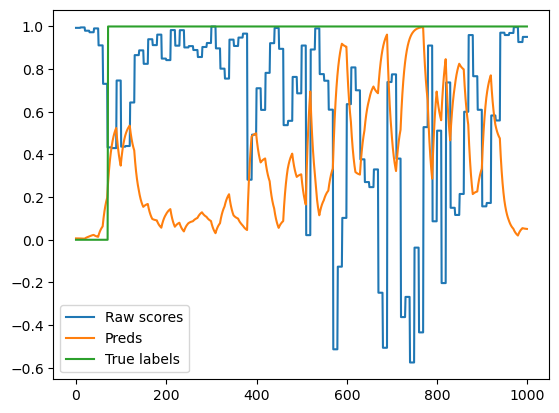

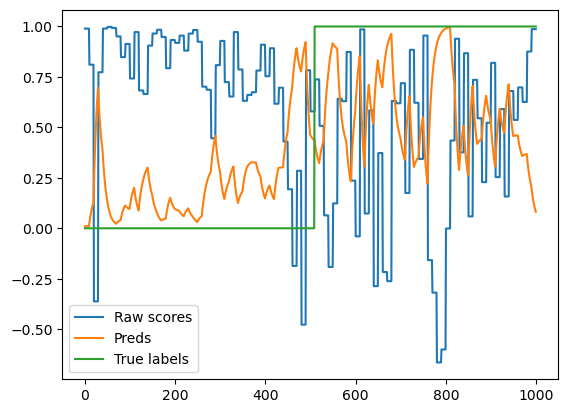

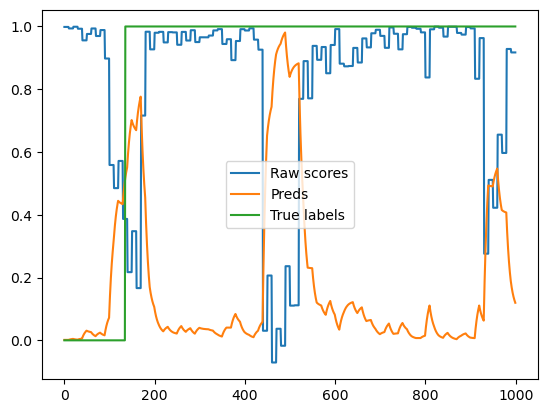

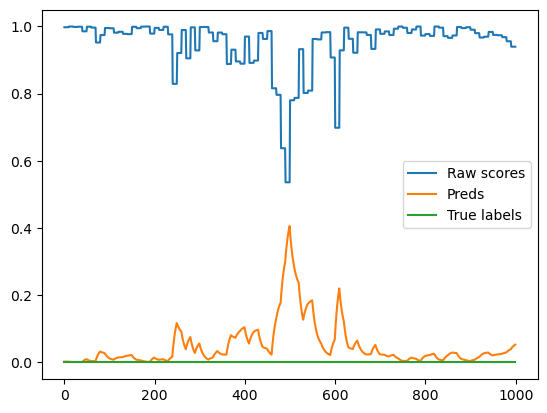

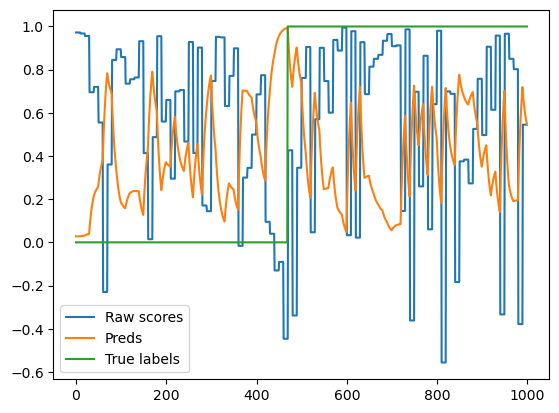

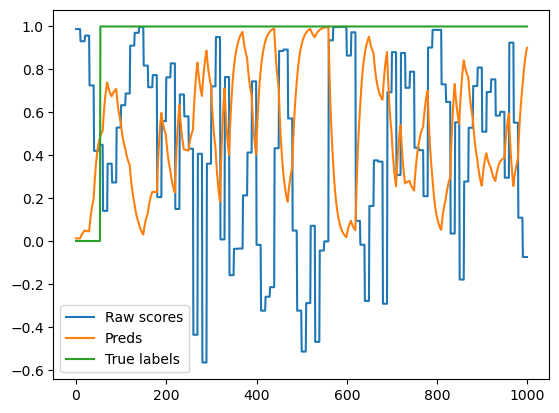

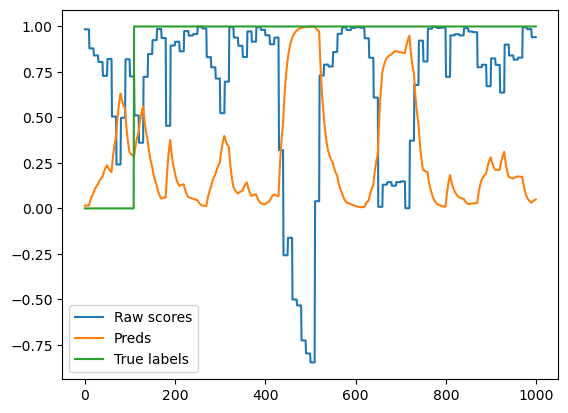

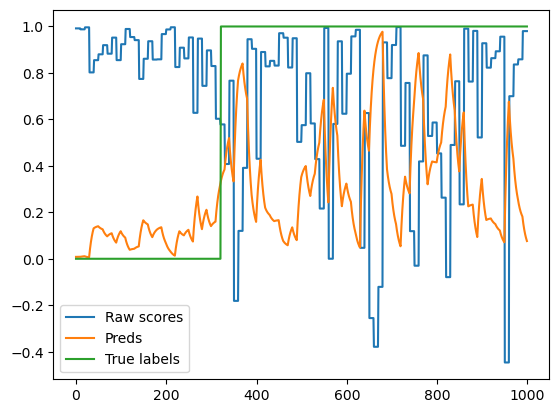

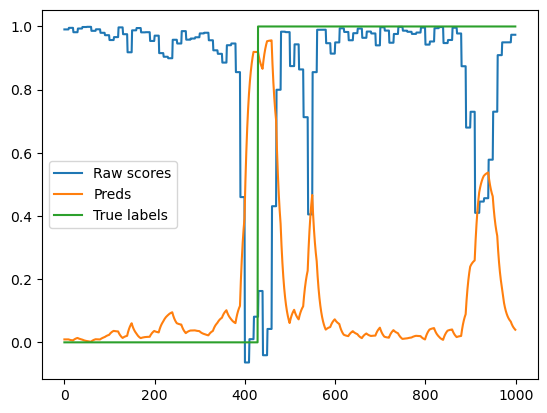

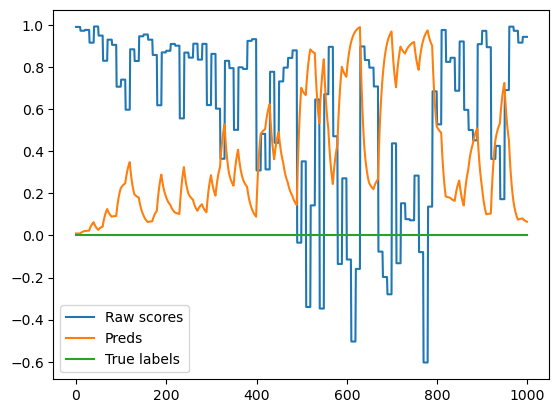

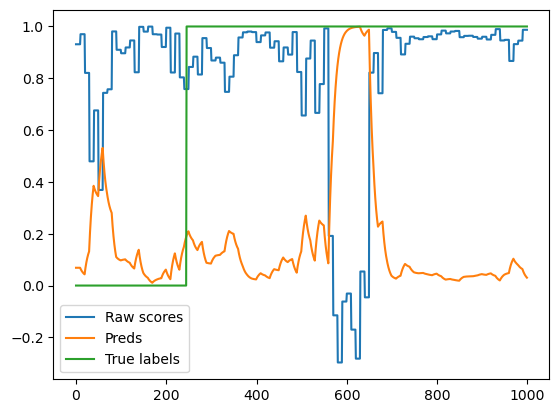

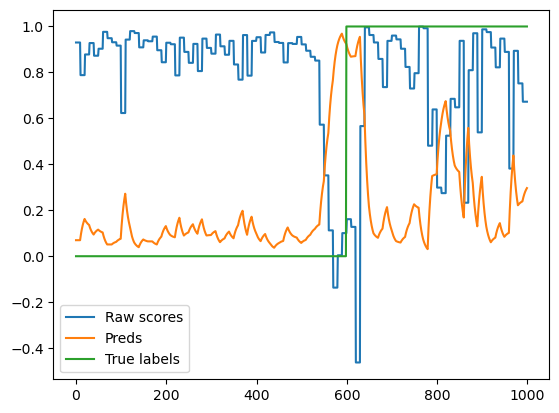

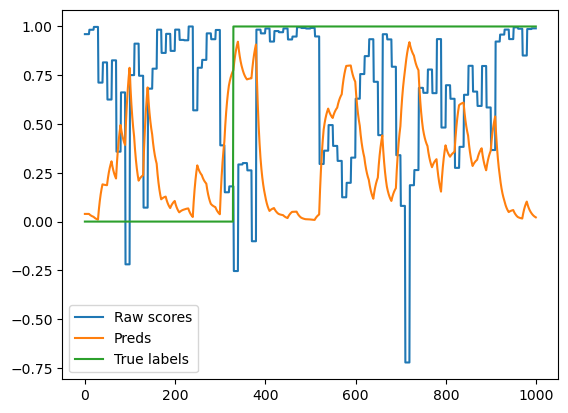

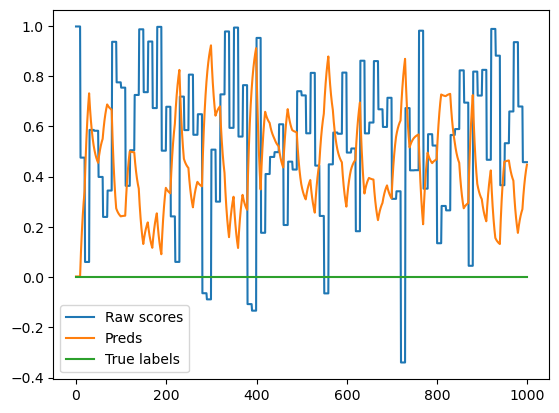

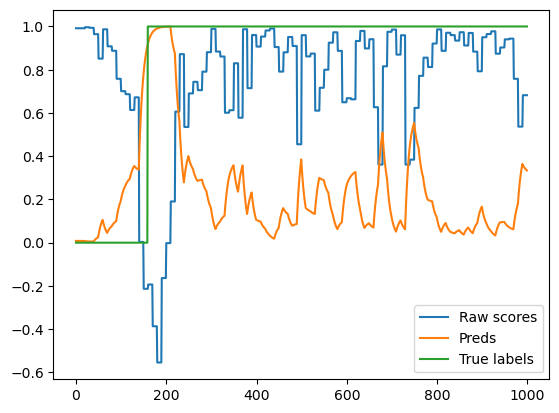

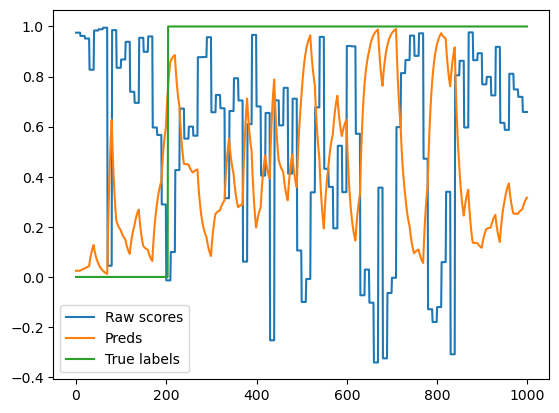

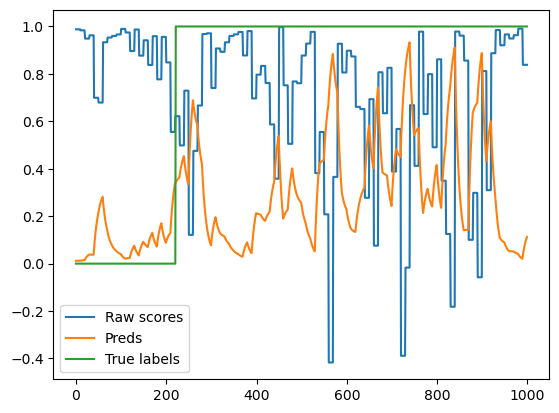

In [5]:
for i in range(20):
    plt.figure()
    plt.plot(raw_scores[i], label="Raw scores")
    plt.plot(preds[i], label="Preds")
    plt.plot(labels_batch[i], label="True labels")
    plt.legend()
    plt.show()

# Ensemble preds

In [6]:
ens_yahoo_tscp = EnsembleCPDModel(args_config, n_models=10)
ens_yahoo_tscp.load_models_list(
    f"temp_saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}"
)

In [7]:
raw_scores_ens_mean, raw_scores_ens_std = ens_yahoo_tscp.predict(
    seq_batch,
    step=args_config["predictions"]["step"],
    alpha=args_config["predictions"]["alpha"]
)

preds_ens_mean = tscp.post_process_tscp_output(raw_scores_ens_mean, alpha=args_config["predictions"]["alpha"])

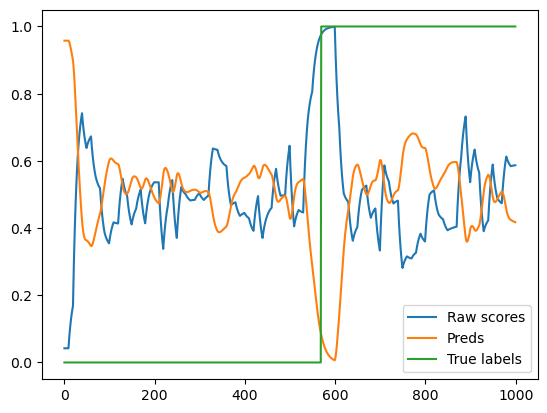

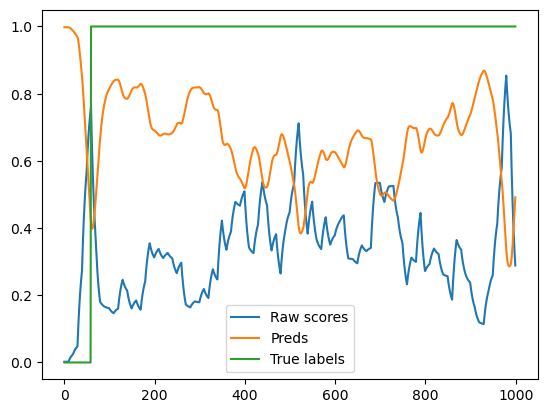

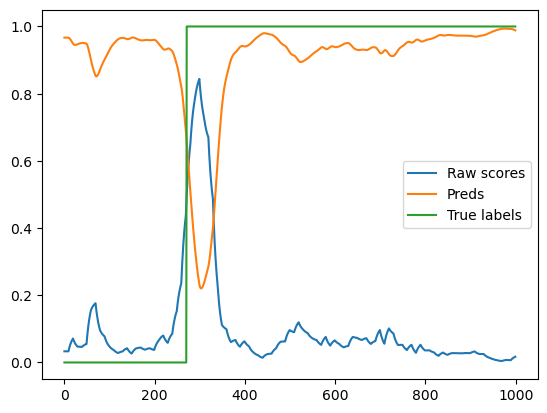

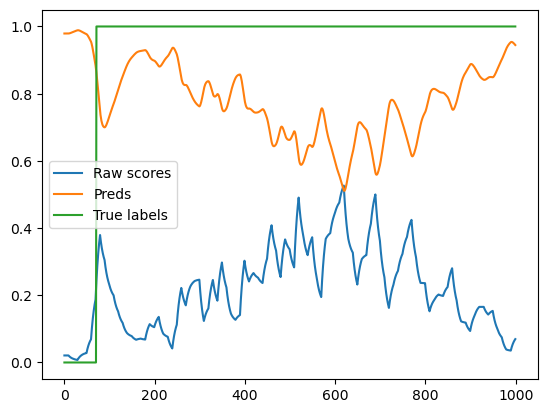

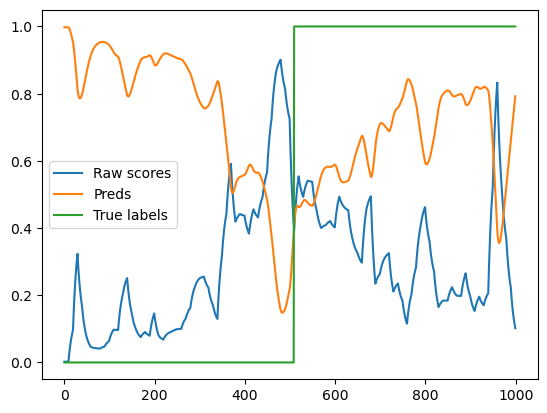

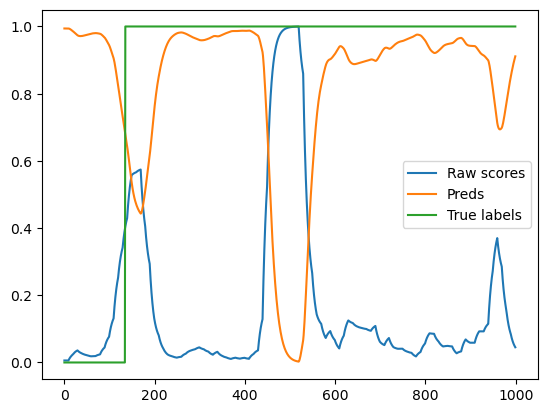

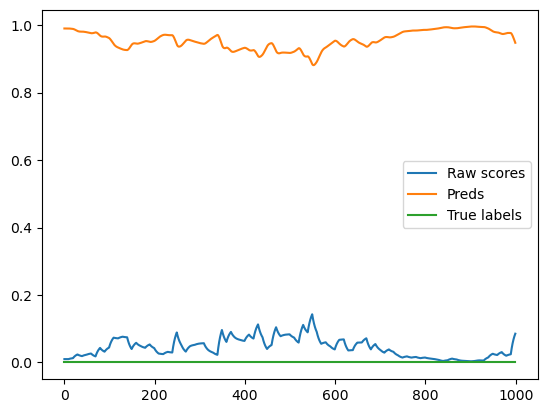

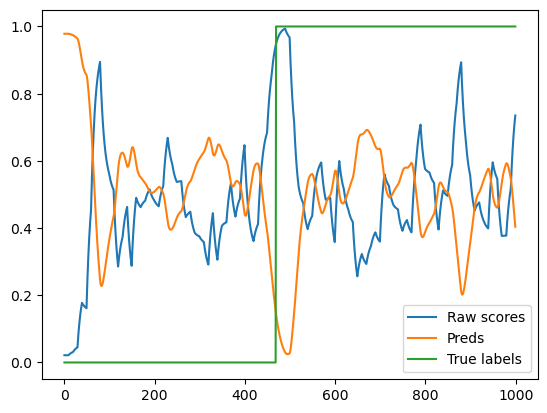

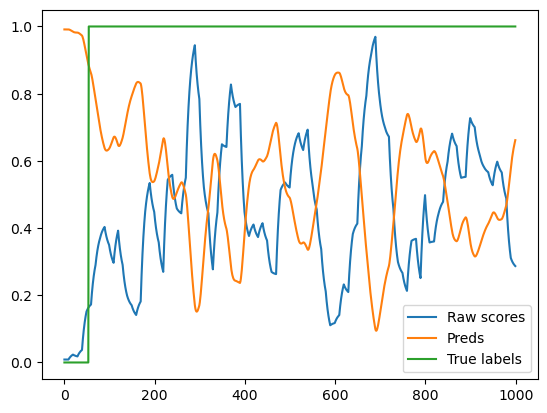

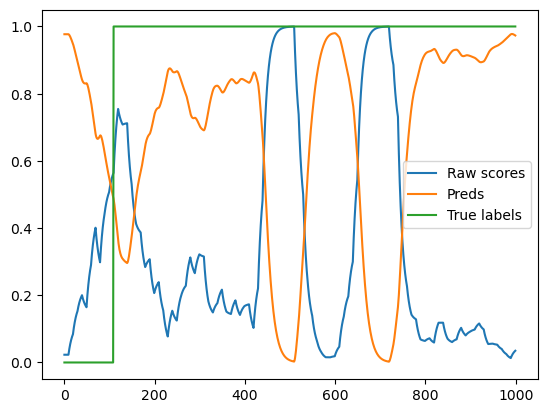

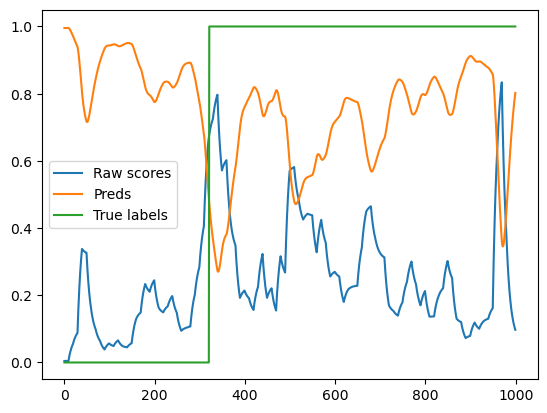

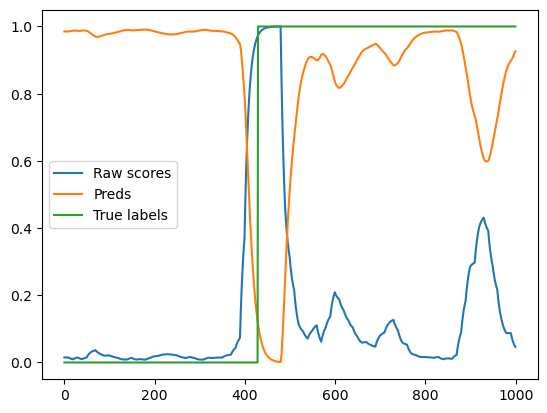

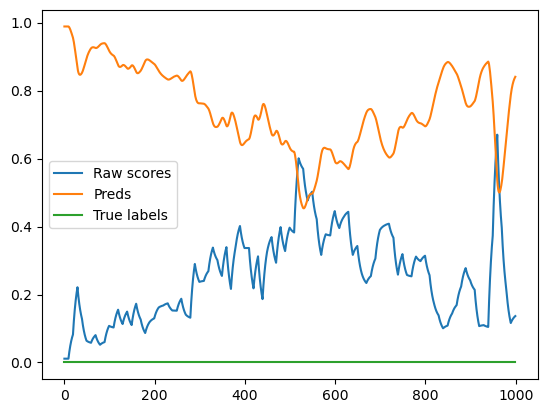

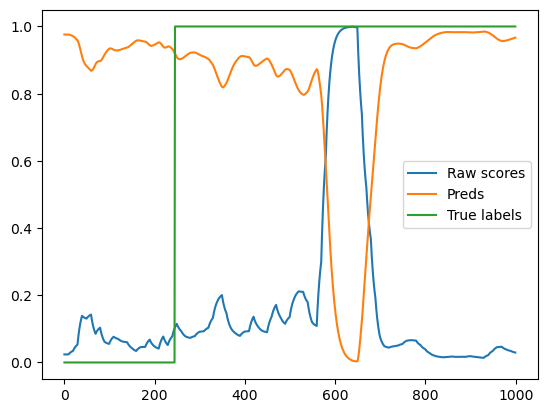

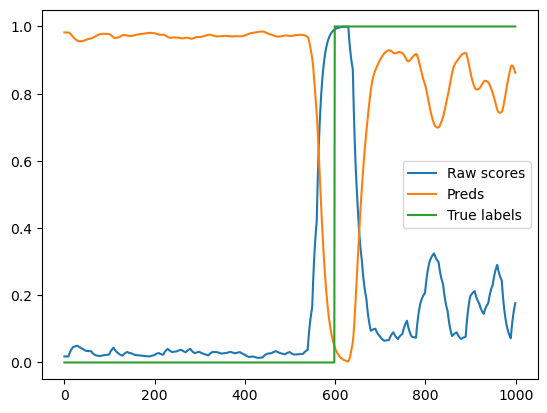

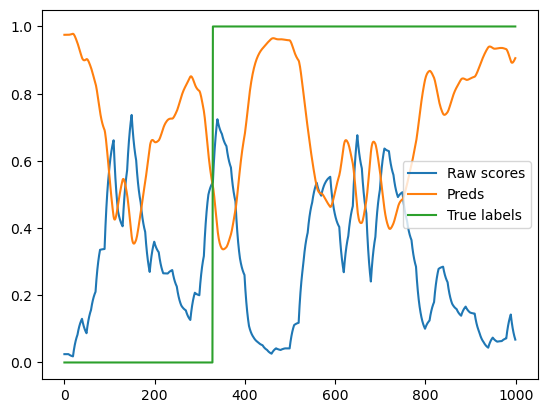

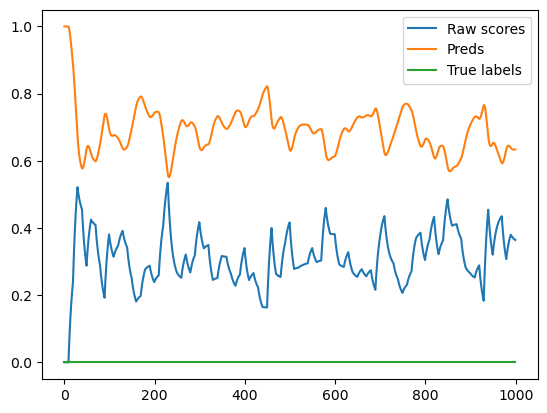

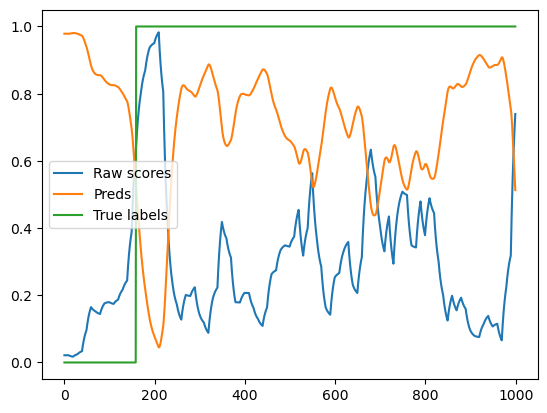

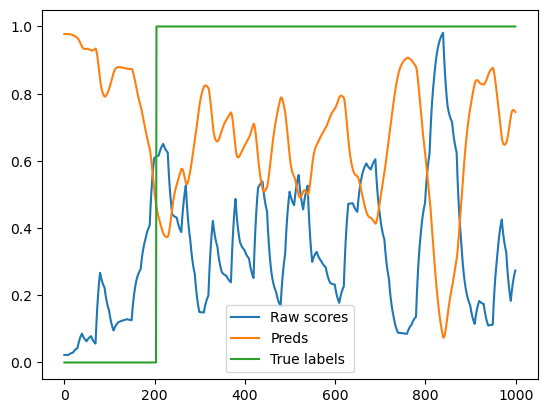

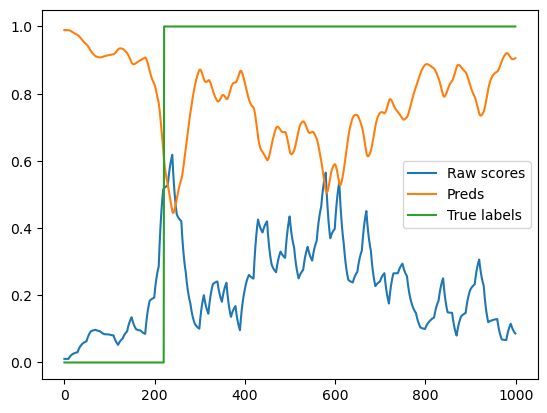

In [8]:
for i in range(20):
    plt.figure()
    plt.plot(raw_scores_ens_mean[i], label="Raw scores")
    #plt.fill_between(
    #    range(len(raw_scores_ens_mean[i])),
    #    raw_scores_ens_mean[i] - raw_scores_ens_std[i],
    #    raw_scores_ens_mean[i] + raw_scores_ens_std[i],
    #    alpha=0.3
    #)
    
    plt.plot(preds_ens_mean[i], label="Preds")
    #plt.fill_between(
    #    range(len(preds_ens_mean[i])),
    #    preds_ens_mean[i] - raw_scores_ens_std[i],
    #    preds_ens_mean[i] + raw_scores_ens_std[i],
    #    alpha=0.3
    #)
    
    
    #plt.plot(preds[i], label="Preds")
    plt.plot(labels_batch[i], label="True labels")
    plt.legend()
    plt.show()

# Metrics

## Single models

In [46]:
audc_lict = []
time_to_fa_list = []
dd_list = []
max_f1_list = []
cover_list = []
max_cover_list = []
max_f1_margin_list = []

seq_len = len(train_dataset[0][0])

margin = 200

threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

for model_num in range(0, 10):
    fix_seeds(model_num)
    
    tscp_model_yahoo = model_utils.get_tscp_models_list(args_config, train_dataset, test_dataset)[0]

    model_name = f'tscp_model_seq_{seq_len}_window_{args_config["model"]["window"]}_model_num_{model_num}'
    save_path = f"temp_saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}/{model_name}.pth"
    
    tscp_model_yahoo.load_state_dict(torch.load(save_path))
    
    metrics_local, (_, max_f1_margin), delay_list, fp_delay_list = \
        metrics.evaluation_pipeline(
            tscp_model_yahoo,
            tscp_model_yahoo.val_dataloader(),
            threshold_list,
            device=args_config["learning"]["accelerator"],
            model_type="tscp",
            scale=args_config["predictions"]["scale"],
            step=args_config["predictions"]["step"],
            alpha=args_config["predictions"]["alpha"],
            verbose=True,
            margin=margin,
    )

    #metrics.write_metrics_to_file(
    #    filename=f"temp_results/{model_type}/{experiments_name}/window_{args_config['model']['window']}/TSCP_single_model_seq_len_{seq_len}_window_{args_config['model']['window']}_step_{args_config['predictions']['step']}.txt",
    #    metrics=(metrics_local, (_, max_f1_margin)),
    #    seed=model_num,
    #    timestamp=datetime.now().strftime("%y%m%dT%H%M%S"),
    #    comment=f"TSCP single model num {model_num}, NEW OUTPUT, {threshold_number} thresholds, step = {args_config['predictions']['step']}, margin = {margin}, alpha = {args_config['predictions']['alpha']}"
    #)

    (_, best_time_to_FA, best_delay, audc, _, 
     best_f1, best_cover, _, max_cover) = metrics_local

    audc_lict.append(audc)
    time_to_fa_list.append(best_time_to_FA)
    dd_list.append(best_delay)
    max_f1_list.append(best_f1)
    cover_list.append(best_cover)
    max_cover_list.append(max_cover)
    max_f1_margin_list.append(max_f1_margin)

print("-" * 100)
print(f"AUDC: {np.round(np.mean(audc_lict), 4)} \pm {np.round(np.std(audc_lict), 4)}")
print(f"Time to FA: {np.round(np.mean(time_to_fa_list), 4)} \pm {np.round(np.std(time_to_fa_list), 4)}")
print(f"DD: {np.round(np.mean(dd_list), 4)} \pm {np.round(np.std(dd_list), 4)}")

print(f"Max F1: {np.round(np.mean(max_f1_list), 4)} \pm {np.round(np.std(max_f1_list), 4)}")
print(f"Cover: {np.round(np.mean(cover_list), 4)} \pm {np.round(np.std(cover_list), 4)}")
print(f"Max Cover: {np.round(np.mean(max_cover_list), 4)} \pm {np.round(np.std(max_cover_list), 4)}")
print(
    f"Max F1, m={margin}: {np.round(np.mean(max_f1_margin_list), 4)} \pm {np.round(np.std(max_f1_margin_list), 4)}"
)

Collectting model's outputs


100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 3, FP: 378, FN: 0, TP: 39, DELAY:3.702380895614624, FP_DELAY:98.2357177734375, COVER: 0.7257915626713444
TN: 3, FP: 377, FN: 0, TP: 40, DELAY:3.738095283508301, FP_DELAY:99.3547592163086, COVER: 0.7268022305116777
TN: 3, FP: 377, FN: 0, TP: 40, DELAY:3.8119046688079834, FP_DELAY:102.0904769897461, COVER: 0.728582879765156
TN: 3, FP: 377, FN: 0, TP: 40, DELAY:4.138095378875732, FP_DELAY:104.52143096923828, COVER: 0.7288737775792649
TN: 3, FP: 377, FN: 0, TP: 40, DELAY:4.785714149475098, FP_DELAY:105.6595230102539, COVER: 0.7285370142889374
TN: 3, FP: 375, FN: 0, TP: 42, DELAY:5.245238304138184, FP_DELAY:107.69285583496094, COVER: 0.7278282344004549
TN: 3, FP: 375, FN: 0, TP: 42, DELAY:5.34761905670166, FP_DELAY:110.95952606201172, COVER: 0.7281400099070444
TN: 3, FP: 375, FN: 0, TP: 42, DELAY:6.116666793823242, FP_DELAY:112.2547607421875, COVER: 0.7271721304378743
TN: 3, FP: 375, FN: 0, TP: 42, DELAY:6.

TN: 37, FP: 65, FN: 203, TP: 115, DELAY:385.8309631347656, FP_DELAY:700.7166748046875, COVER: 0.7348183405101367
TN: 37, FP: 59, FN: 221, TP: 103, DELAY:404.6452331542969, FP_DELAY:732.0928344726562, COVER: 0.7285668310020664
TN: 37, FP: 55, FN: 226, TP: 102, DELAY:412.6785583496094, FP_DELAY:741.8905029296875, COVER: 0.7272423742093606
TN: 37, FP: 55, FN: 232, TP: 96, DELAY:423.0047607421875, FP_DELAY:752.9738159179688, COVER: 0.7258916594385131
TN: 37, FP: 55, FN: 232, TP: 96, DELAY:423.21905517578125, FP_DELAY:753.104736328125, COVER: 0.7259574194883371
TN: 37, FP: 49, FN: 232, TP: 102, DELAY:423.8952331542969, FP_DELAY:753.2333374023438, COVER: 0.7261885454981046
TN: 37, FP: 49, FN: 233, TP: 101, DELAY:424.202392578125, FP_DELAY:754.5737915039062, COVER: 0.7261656548416398
TN: 38, FP: 47, FN: 234, TP: 101, DELAY:427.8333435058594, FP_DELAY:756.9500122070312, COVER: 0.7251839159738573
TN: 40, FP: 44, FN: 237, TP: 99, DELAY:429.28570556640625, FP_DELAY:763.3214111328125, COVER: 0.725

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 0, FP: 407, FN: 0, TP: 13, DELAY:0.24523809552192688, FP_DELAY:37.05714416503906, COVER: 0.6984030369402068
TN: 0, FP: 407, FN: 0, TP: 13, DELAY:0.2571428716182709, FP_DELAY:41.876190185546875, COVER: 0.7014331475252313
TN: 0, FP: 406, FN: 0, TP: 14, DELAY:0.2666666805744171, FP_DELAY:45.45476150512695, COVER: 0.702791744194618
TN: 0, FP: 405, FN: 0, TP: 15, DELAY:0.28333333134651184, FP_DELAY:49.46190643310547, COVER: 0.7039653680428282
TN: 0, FP: 405, FN: 0, TP: 15, DELAY:0.30714285373687744, FP_DELAY:53.516666412353516, COVER: 0.7064001864024476
TN: 0, FP: 405, FN: 0, TP: 15, DELAY:0.31904762983322144, FP_DELAY:62.36666488647461, COVER: 0.7124345743672688
TN: 0, FP: 405, FN: 0, TP: 15, DELAY:0.3452380895614624, FP_DELAY:67.7357177734375, COVER: 0.7157486327649004
TN: 0, FP: 405, FN: 0, TP: 15, DELAY:0.3857142925262451, FP_DELAY:71.94523620605469, COVER: 0.7184720063084454
TN: 0, FP: 405, FN: 0, TP: 

TN: 43, FP: 67, FN: 150, TP: 160, DELAY:321.20477294921875, FP_DELAY:630.1476440429688, COVER: 0.7772052358123199
TN: 43, FP: 61, FN: 150, TP: 166, DELAY:321.5523681640625, FP_DELAY:630.278564453125, COVER: 0.7770991590304285
TN: 43, FP: 50, FN: 151, TP: 176, DELAY:325.5881042480469, FP_DELAY:632.6071166992188, COVER: 0.7757575403620254
TN: 43, FP: 45, FN: 153, TP: 179, DELAY:335.98333740234375, FP_DELAY:635.6166381835938, COVER: 0.7686889199811825
TN: 43, FP: 45, FN: 153, TP: 179, DELAY:336.4381103515625, FP_DELAY:635.721435546875, COVER: 0.7684216532564695
TN: 43, FP: 44, FN: 170, TP: 163, DELAY:356.0976257324219, FP_DELAY:665.4952392578125, COVER: 0.7676356097384293
TN: 43, FP: 43, FN: 178, TP: 156, DELAY:371.009521484375, FP_DELAY:681.4928588867188, COVER: 0.7641526477376358
TN: 43, FP: 43, FN: 179, TP: 155, DELAY:373.5428466796875, FP_DELAY:683.7857055664062, COVER: 0.763702005748247
TN: 43, FP: 43, FN: 184, TP: 150, DELAY:383.48333740234375, FP_DELAY:693.6809692382812, COVER: 0.7

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 3, FP: 385, FN: 3, TP: 29, DELAY:5.497619152069092, FP_DELAY:80.98332977294922, COVER: 0.7214575649654543
TN: 3, FP: 385, FN: 3, TP: 29, DELAY:5.538095474243164, FP_DELAY:87.21428680419922, COVER: 0.7256896989682544
TN: 3, FP: 385, FN: 3, TP: 29, DELAY:5.690476417541504, FP_DELAY:88.61666870117188, COVER: 0.7266305659230974
TN: 3, FP: 385, FN: 3, TP: 29, DELAY:5.788095474243164, FP_DELAY:93.91190338134766, COVER: 0.7322406908390979
TN: 3, FP: 384, FN: 3, TP: 30, DELAY:6.069047451019287, FP_DELAY:96.23809814453125, COVER: 0.7339413774164121
TN: 3, FP: 373, FN: 3, TP: 41, DELAY:6.202381134033203, FP_DELAY:97.5047607421875, COVER: 0.7351878783241564
TN: 3, FP: 372, FN: 3, TP: 42, DELAY:6.357142925262451, FP_DELAY:99.58333587646484, COVER: 0.7371367851679995
TN: 3, FP: 371, FN: 4, TP: 42, DELAY:7.045238018035889, FP_DELAY:105.82380676269531, COVER: 0.7408859437933285
TN: 3, FP: 371, FN: 4, TP: 42, DELAY:7.

TN: 36, FP: 80, FN: 233, TP: 71, DELAY:418.9237976074219, FP_DELAY:746.1666870117188, COVER: 0.7302179217855055
TN: 36, FP: 79, FN: 233, TP: 72, DELAY:419.44287109375, FP_DELAY:746.5737915039062, COVER: 0.7307675063697673
TN: 36, FP: 79, FN: 233, TP: 72, DELAY:419.5881042480469, FP_DELAY:746.7380981445312, COVER: 0.7309153517405775
TN: 36, FP: 72, FN: 242, TP: 70, DELAY:428.3190612792969, FP_DELAY:757.5499877929688, COVER: 0.7245058501810785
TN: 36, FP: 69, FN: 242, TP: 73, DELAY:428.471435546875, FP_DELAY:757.721435546875, COVER: 0.7246982943686852
TN: 36, FP: 69, FN: 242, TP: 73, DELAY:428.6261901855469, FP_DELAY:758.278564453125, COVER: 0.7249792985171758
TN: 36, FP: 54, FN: 244, TP: 86, DELAY:430.1095275878906, FP_DELAY:762.0119018554688, COVER: 0.7251812046050464
TN: 38, FP: 52, FN: 244, TP: 86, DELAY:430.3143005371094, FP_DELAY:766.6094970703125, COVER: 0.7254922010842446
TN: 42, FP: 36, FN: 257, TP: 85, DELAY:441.7738037109375, FP_DELAY:797.5214233398438, COVER: 0.73720012209717

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 3, FP: 404, FN: 0, TP: 13, DELAY:0.18333333730697632, FP_DELAY:57.402381896972656, COVER: 0.708619352181181
TN: 3, FP: 404, FN: 0, TP: 13, DELAY:0.20714285969734192, FP_DELAY:62.411903381347656, COVER: 0.7138565556286719
TN: 3, FP: 404, FN: 0, TP: 13, DELAY:0.23095238208770752, FP_DELAY:65.04523468017578, COVER: 0.7163128853006261
TN: 3, FP: 404, FN: 0, TP: 13, DELAY:0.23333333432674408, FP_DELAY:66.8499984741211, COVER: 0.7178542815342396
TN: 3, FP: 403, FN: 0, TP: 14, DELAY:0.25238096714019775, FP_DELAY:68.60952758789062, COVER: 0.7197042079569617
TN: 3, FP: 403, FN: 0, TP: 14, DELAY:0.261904776096344, FP_DELAY:72.11190795898438, COVER: 0.7217229188018319
TN: 3, FP: 403, FN: 0, TP: 14, DELAY:0.2857142984867096, FP_DELAY:74.16190338134766, COVER: 0.7227422419856335
TN: 3, FP: 402, FN: 0, TP: 15, DELAY:0.32380953431129456, FP_DELAY:77.4000015258789, COVER: 0.7255589136400968
TN: 3, FP: 402, FN: 0, TP: 

TN: 43, FP: 31, FN: 180, TP: 166, DELAY:369.1309509277344, FP_DELAY:670.2238159179688, COVER: 0.7368357112673682
TN: 43, FP: 30, FN: 182, TP: 165, DELAY:369.6737976074219, FP_DELAY:673.7357177734375, COVER: 0.7367849353771504
TN: 43, FP: 29, FN: 183, TP: 165, DELAY:370.2071533203125, FP_DELAY:674.8571166992188, COVER: 0.7365559171746513
TN: 43, FP: 22, FN: 183, TP: 172, DELAY:370.5976257324219, FP_DELAY:674.9119262695312, COVER: 0.7362773120423437
TN: 43, FP: 22, FN: 183, TP: 172, DELAY:370.9666748046875, FP_DELAY:674.9547729492188, COVER: 0.7359905977625547
TN: 43, FP: 22, FN: 184, TP: 171, DELAY:373.5690612792969, FP_DELAY:677.316650390625, COVER: 0.735751367210142
TN: 43, FP: 21, FN: 188, TP: 168, DELAY:375.6666564941406, FP_DELAY:683.9642944335938, COVER: 0.7362277358856153
TN: 43, FP: 20, FN: 188, TP: 169, DELAY:376.5857238769531, FP_DELAY:684.0119018554688, COVER: 0.73530203577981
TN: 43, FP: 10, FN: 188, TP: 179, DELAY:377.00714111328125, FP_DELAY:684.0595092773438, COVER: 0.734

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 3, FP: 402, FN: 0, TP: 15, DELAY:0.36666667461395264, FP_DELAY:71.87857055664062, COVER: 0.7184866467470935
TN: 3, FP: 402, FN: 0, TP: 15, DELAY:0.380952388048172, FP_DELAY:73.69999694824219, COVER: 0.7203290040444152
TN: 3, FP: 401, FN: 0, TP: 16, DELAY:0.39523810148239136, FP_DELAY:77.31904602050781, COVER: 0.7225707666481657
TN: 3, FP: 401, FN: 0, TP: 16, DELAY:0.4166666567325592, FP_DELAY:80.58809661865234, COVER: 0.7268132457371965
TN: 3, FP: 401, FN: 0, TP: 16, DELAY:0.43095237016677856, FP_DELAY:85.54762268066406, COVER: 0.7289455867317469
TN: 3, FP: 400, FN: 0, TP: 17, DELAY:0.45476189255714417, FP_DELAY:86.52381134033203, COVER: 0.7292091805292709
TN: 3, FP: 399, FN: 0, TP: 18, DELAY:0.4833333194255829, FP_DELAY:88.1595230102539, COVER: 0.7298860537845547
TN: 3, FP: 398, FN: 0, TP: 19, DELAY:0.523809552192688, FP_DELAY:95.06666564941406, COVER: 0.7337860743464008
TN: 3, FP: 398, FN: 1, TP: 18,

TN: 43, FP: 59, FN: 211, TP: 107, DELAY:403.70001220703125, FP_DELAY:724.990478515625, COVER: 0.7323472428167511
TN: 43, FP: 56, FN: 211, TP: 110, DELAY:403.9118957519531, FP_DELAY:725.1309814453125, COVER: 0.7324291418388866
TN: 43, FP: 51, FN: 212, TP: 114, DELAY:404.21905517578125, FP_DELAY:727.1142578125, COVER: 0.7324895809467634
TN: 43, FP: 51, FN: 212, TP: 114, DELAY:404.45477294921875, FP_DELAY:727.2190551757812, COVER: 0.7324647273945228
TN: 43, FP: 41, FN: 212, TP: 124, DELAY:404.6714172363281, FP_DELAY:727.3309326171875, COVER: 0.7324833472289859
TN: 43, FP: 41, FN: 212, TP: 124, DELAY:404.9666748046875, FP_DELAY:727.4285888671875, COVER: 0.7323933950791148
TN: 43, FP: 41, FN: 212, TP: 124, DELAY:405.22857666015625, FP_DELAY:727.490478515625, COVER: 0.7322806112602437
TN: 43, FP: 41, FN: 212, TP: 124, DELAY:405.490478515625, FP_DELAY:727.5737915039062, COVER: 0.7321994181388806
TN: 43, FP: 41, FN: 212, TP: 124, DELAY:405.7738037109375, FP_DELAY:727.6690673828125, COVER: 0.73

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 3, FP: 387, FN: 0, TP: 30, DELAY:3.661904811859131, FP_DELAY:95.45952606201172, COVER: 0.737077380429906
TN: 3, FP: 387, FN: 0, TP: 30, DELAY:3.9452381134033203, FP_DELAY:97.3547592163086, COVER: 0.7368882469129037
TN: 3, FP: 387, FN: 0, TP: 30, DELAY:4.140476226806641, FP_DELAY:99.69285583496094, COVER: 0.7386296469614243
TN: 3, FP: 386, FN: 0, TP: 31, DELAY:4.400000095367432, FP_DELAY:103.42381286621094, COVER: 0.7416217818420314
TN: 3, FP: 386, FN: 0, TP: 31, DELAY:4.7928571701049805, FP_DELAY:106.88095092773438, COVER: 0.7408064560755203
TN: 3, FP: 386, FN: 0, TP: 31, DELAY:4.895237922668457, FP_DELAY:109.51667022705078, COVER: 0.7430582887034786
TN: 3, FP: 386, FN: 0, TP: 31, DELAY:6.407142639160156, FP_DELAY:117.36190795898438, COVER: 0.7497403001650613
TN: 3, FP: 386, FN: 0, TP: 31, DELAY:6.540476322174072, FP_DELAY:122.82857513427734, COVER: 0.7545425746780088
TN: 3, FP: 385, FN: 0, TP: 32, DEL

TN: 39, FP: 48, FN: 227, TP: 106, DELAY:417.1881103515625, FP_DELAY:737.4190673828125, COVER: 0.7249388892247621
TN: 39, FP: 48, FN: 227, TP: 106, DELAY:417.3809509277344, FP_DELAY:737.5166625976562, COVER: 0.7249563449549885
TN: 39, FP: 45, FN: 230, TP: 106, DELAY:421.4309387207031, FP_DELAY:744.2880859375, COVER: 0.7244822710524197
TN: 39, FP: 45, FN: 230, TP: 106, DELAY:421.6809387207031, FP_DELAY:744.3928833007812, COVER: 0.7244727588083043
TN: 40, FP: 43, FN: 230, TP: 107, DELAY:423.30712890625, FP_DELAY:746.9214477539062, COVER: 0.7238309825891299
TN: 40, FP: 39, FN: 231, TP: 110, DELAY:424.9190368652344, FP_DELAY:749.0690307617188, COVER: 0.7237728750409141
TN: 40, FP: 39, FN: 238, TP: 103, DELAY:436.1166687011719, FP_DELAY:762.2380981445312, COVER: 0.7239936063368456
TN: 41, FP: 23, FN: 239, TP: 117, DELAY:436.4214172363281, FP_DELAY:766.4071655273438, COVER: 0.7242182435503582
TN: 41, FP: 22, FN: 244, TP: 113, DELAY:443.528564453125, FP_DELAY:776.5880737304688, COVER: 0.723495

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 0, FP: 409, FN: 0, TP: 11, DELAY:0.190476194024086, FP_DELAY:33.67380905151367, COVER: 0.7008648077056737
TN: 0, FP: 408, FN: 0, TP: 12, DELAY:0.19761905074119568, FP_DELAY:36.92380905151367, COVER: 0.7033044834772082
TN: 0, FP: 407, FN: 0, TP: 13, DELAY:0.2142857164144516, FP_DELAY:39.53571319580078, COVER: 0.7055059926386841
TN: 0, FP: 407, FN: 0, TP: 13, DELAY:0.22380952537059784, FP_DELAY:41.61666488647461, COVER: 0.7046249290739797
TN: 0, FP: 406, FN: 0, TP: 14, DELAY:0.23571428656578064, FP_DELAY:42.60952377319336, COVER: 0.7046979368747156
TN: 0, FP: 406, FN: 0, TP: 14, DELAY:0.25238096714019775, FP_DELAY:43.94047546386719, COVER: 0.7053140820125033
TN: 0, FP: 406, FN: 0, TP: 14, DELAY:0.25952380895614624, FP_DELAY:46.93095397949219, COVER: 0.7067104886394399
TN: 0, FP: 405, FN: 0, TP: 15, DELAY:0.2785714268684387, FP_DELAY:53.4476203918457, COVER: 0.7102157311069499
TN: 0, FP: 405, FN: 0, TP: 1

TN: 43, FP: 75, FN: 164, TP: 138, DELAY:339.6690368652344, FP_DELAY:648.5690307617188, COVER: 0.7640436000544187
TN: 43, FP: 70, FN: 164, TP: 143, DELAY:339.98333740234375, FP_DELAY:648.7047729492188, COVER: 0.7640435586510033
TN: 43, FP: 70, FN: 164, TP: 143, DELAY:340.278564453125, FP_DELAY:648.8666381835938, COVER: 0.7641233841938082
TN: 43, FP: 69, FN: 164, TP: 144, DELAY:340.547607421875, FP_DELAY:649.0047607421875, COVER: 0.7641217530475728
TN: 43, FP: 67, FN: 165, TP: 145, DELAY:343.05950927734375, FP_DELAY:651.4119262695312, COVER: 0.7640008066631752
TN: 43, FP: 67, FN: 165, TP: 145, DELAY:343.3761901855469, FP_DELAY:652.7999877929688, COVER: 0.7652573171253855
TN: 43, FP: 57, FN: 165, TP: 155, DELAY:343.7642822265625, FP_DELAY:652.9547729492188, COVER: 0.7651915691666307
TN: 43, FP: 47, FN: 167, TP: 163, DELAY:347.971435546875, FP_DELAY:657.40478515625, COVER: 0.764891558807492
TN: 43, FP: 39, FN: 173, TP: 165, DELAY:357.26904296875, FP_DELAY:665.8023681640625, COVER: 0.759097

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 3, FP: 371, FN: 4, TP: 42, DELAY:8.180952072143555, FP_DELAY:105.67381286621094, COVER: 0.7339123450928055
TN: 3, FP: 370, FN: 4, TP: 43, DELAY:8.264286041259766, FP_DELAY:107.33333587646484, COVER: 0.7351809349384715
TN: 3, FP: 370, FN: 4, TP: 43, DELAY:8.478571891784668, FP_DELAY:113.74761962890625, COVER: 0.7344173018561055
TN: 3, FP: 370, FN: 4, TP: 43, DELAY:8.592857360839844, FP_DELAY:116.37380981445312, COVER: 0.7359314079670739
TN: 3, FP: 369, FN: 4, TP: 44, DELAY:8.697619438171387, FP_DELAY:117.29285430908203, COVER: 0.736448633264341
TN: 3, FP: 368, FN: 4, TP: 45, DELAY:8.807143211364746, FP_DELAY:119.240478515625, COVER: 0.7379313412353748
TN: 3, FP: 368, FN: 4, TP: 45, DELAY:8.928571701049805, FP_DELAY:122.99761962890625, COVER: 0.7411089772395035
TN: 3, FP: 367, FN: 4, TP: 46, DELAY:9.040475845336914, FP_DELAY:125.23809814453125, COVER: 0.7414603815714349
TN: 3, FP: 366, FN: 4, TP: 47, DEL

TN: 36, FP: 80, FN: 184, TP: 120, DELAY:357.7119140625, FP_DELAY:661.6166381835938, COVER: 0.7417896937626668
TN: 36, FP: 80, FN: 184, TP: 120, DELAY:359.240478515625, FP_DELAY:662.0428466796875, COVER: 0.7400027080991038
TN: 36, FP: 80, FN: 184, TP: 120, DELAY:359.54046630859375, FP_DELAY:662.2285766601562, COVER: 0.7399767408390923
TN: 36, FP: 79, FN: 184, TP: 121, DELAY:359.79522705078125, FP_DELAY:662.4285888671875, COVER: 0.7400561898412399
TN: 36, FP: 79, FN: 184, TP: 121, DELAY:359.98095703125, FP_DELAY:662.6166381835938, COVER: 0.7401534606979548
TN: 36, FP: 79, FN: 184, TP: 121, DELAY:361.50714111328125, FP_DELAY:663.009521484375, COVER: 0.739238780344905
TN: 36, FP: 79, FN: 184, TP: 121, DELAY:361.77618408203125, FP_DELAY:663.1857299804688, COVER: 0.7392547622197538
TN: 36, FP: 74, FN: 185, TP: 125, DELAY:362.0833435058594, FP_DELAY:666.028564453125, COVER: 0.7386612204764835
TN: 36, FP: 70, FN: 187, TP: 127, DELAY:365.9476318359375, FP_DELAY:671.0714111328125, COVER: 0.73803

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 3, FP: 400, FN: 0, TP: 17, DELAY:0.5833333134651184, FP_DELAY:82.64762115478516, COVER: 0.7248611733364528
TN: 3, FP: 400, FN: 0, TP: 17, DELAY:0.6023809313774109, FP_DELAY:85.64047241210938, COVER: 0.7272317635888496
TN: 3, FP: 399, FN: 0, TP: 18, DELAY:0.6238095164299011, FP_DELAY:88.96428680419922, COVER: 0.7261292850954947
TN: 3, FP: 399, FN: 0, TP: 18, DELAY:0.6523809432983398, FP_DELAY:91.13571166992188, COVER: 0.7284402493654145
TN: 3, FP: 399, FN: 0, TP: 18, DELAY:0.6833333373069763, FP_DELAY:94.04047393798828, COVER: 0.7300698622616262
TN: 3, FP: 398, FN: 0, TP: 19, DELAY:0.7833333611488342, FP_DELAY:95.73094940185547, COVER: 0.730697205478807
TN: 3, FP: 397, FN: 0, TP: 20, DELAY:0.800000011920929, FP_DELAY:96.81666564941406, COVER: 0.7310450576937472
TN: 3, FP: 397, FN: 0, TP: 20, DELAY:1.2904762029647827, FP_DELAY:100.49285888671875, COVER: 0.7331753368614384
TN: 3, FP: 397, FN: 0, TP: 20, D

TN: 43, FP: 57, FN: 192, TP: 128, DELAY:389.9023742675781, FP_DELAY:695.9381103515625, COVER: 0.7321708329095009
TN: 43, FP: 53, FN: 192, TP: 132, DELAY:390.0762023925781, FP_DELAY:696.0809326171875, COVER: 0.73232352951754
TN: 43, FP: 45, FN: 192, TP: 140, DELAY:390.3642883300781, FP_DELAY:696.1904907226562, COVER: 0.7323260942683613
TN: 43, FP: 44, FN: 192, TP: 141, DELAY:390.6737976074219, FP_DELAY:696.297607421875, COVER: 0.7322710307598834
TN: 43, FP: 44, FN: 192, TP: 141, DELAY:391.009521484375, FP_DELAY:696.3905029296875, COVER: 0.7321673386644594
TN: 43, FP: 39, FN: 192, TP: 146, DELAY:391.29998779296875, FP_DELAY:696.4952392578125, COVER: 0.7321262999045031
TN: 43, FP: 39, FN: 192, TP: 146, DELAY:391.6000061035156, FP_DELAY:696.5904541015625, COVER: 0.732048824215484
TN: 43, FP: 39, FN: 192, TP: 146, DELAY:391.9142761230469, FP_DELAY:696.6762084960938, COVER: 0.7319188140433213
TN: 43, FP: 39, FN: 192, TP: 146, DELAY:392.26190185546875, FP_DELAY:696.7904663085938, COVER: 0.731

100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 0, FP: 404, FN: 0, TP: 16, DELAY:0.8190476298332214, FP_DELAY:67.53333282470703, COVER: 0.7172852086183147
TN: 0, FP: 404, FN: 0, TP: 16, DELAY:0.8309524059295654, FP_DELAY:70.24285888671875, COVER: 0.7199289564981703
TN: 0, FP: 404, FN: 0, TP: 16, DELAY:0.8428571224212646, FP_DELAY:74.74761962890625, COVER: 0.7230805932126786
TN: 0, FP: 404, FN: 0, TP: 16, DELAY:0.8619047403335571, FP_DELAY:77.94761657714844, COVER: 0.7219132148923879
TN: 0, FP: 404, FN: 0, TP: 16, DELAY:0.8738095164299011, FP_DELAY:79.65714263916016, COVER: 0.7213986150246128
TN: 0, FP: 403, FN: 0, TP: 17, DELAY:0.9095237851142883, FP_DELAY:85.13333129882812, COVER: 0.7265398787375469
TN: 0, FP: 403, FN: 0, TP: 17, DELAY:0.9261904954910278, FP_DELAY:88.62619018554688, COVER: 0.7278508560745565
TN: 0, FP: 402, FN: 0, TP: 18, DELAY:0.973809540271759, FP_DELAY:95.43095397949219, COVER: 0.730215599851149
TN: 0, FP: 401, FN: 0, TP: 19, DE

TN: 43, FP: 52, FN: 181, TP: 144, DELAY:382.7261962890625, FP_DELAY:673.9309692382812, COVER: 0.7314682961584255
TN: 43, FP: 50, FN: 192, TP: 135, DELAY:390.79998779296875, FP_DELAY:693.4571533203125, COVER: 0.7351929866448056
TN: 43, FP: 46, FN: 192, TP: 139, DELAY:391.03570556640625, FP_DELAY:693.547607421875, COVER: 0.735246347433685
TN: 43, FP: 41, FN: 192, TP: 144, DELAY:392.47857666015625, FP_DELAY:693.6571655273438, COVER: 0.7340667650388507
TN: 43, FP: 41, FN: 192, TP: 144, DELAY:392.7547607421875, FP_DELAY:693.7523803710938, COVER: 0.734053925074438
TN: 43, FP: 41, FN: 193, TP: 143, DELAY:393.1642761230469, FP_DELAY:695.4452514648438, COVER: 0.734001010674465
TN: 43, FP: 40, FN: 193, TP: 144, DELAY:393.5047607421875, FP_DELAY:695.5357055664062, COVER: 0.7339322803162804
TN: 43, FP: 40, FN: 193, TP: 144, DELAY:393.8452453613281, FP_DELAY:695.6309814453125, COVER: 0.7338718587923687
TN: 43, FP: 34, FN: 193, TP: 150, DELAY:394.1881103515625, FP_DELAY:695.7238159179688, COVER: 0.7

## Ensemble

In [47]:
margin = 200

ens_yahoo_tscp = EnsembleCPDModel(args_config, n_models=10)
ens_yahoo_tscp.load_models_list(
    f"temp_saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}"
)

test_dataset = ens_yahoo_tscp.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size=args_config['learning']['batch_size'], shuffle=False)

metrics_local, (_, max_f1_margin), delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(
        ens_yahoo_tscp,
        test_dataloader,
        threshold_list,
        device="cpu",
        model_type="ensemble",
        scale=args_config["predictions"]["scale"],
        step=args_config['predictions']['step'],
        alpha=args_config['predictions']['alpha'],
        verbose=True,
        margin=margin,
)

#metrics.write_metrics_to_file(
#    filename=f"temp_results/{model_type}/{experiments_name}/window_{args_config['model']['window']}/TSCP_ensemble_model_seq_len_{seq_len}_window_{args_config['model']['window']}_step_{args_config['predictions']['step']}.txt",
#    metrics=(metrics_local, (_, max_f1_margin)),
#    seed=0,
#    timestamp=datetime.now().strftime("%y%m%dT%H%M%S"),
#    comment=f"TSCP ensemble, AVG RAW SCORES, NEW OUTPUT, {threshold_number} thresholds, step = {args_config['predictions']['step']}, margin = {margin}, alpha = {args_config['predictions']['alpha']}"
#)

Collectting model's outputs


100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  8.42s/it]


TN: 0, FP: 420, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6888599047619047
TN: 3, FP: 405, FN: 0, TP: 12, DELAY:0.2023809552192688, FP_DELAY:66.19523620605469, COVER: 0.7176748123170704
TN: 3, FP: 405, FN: 0, TP: 12, DELAY:0.22142857313156128, FP_DELAY:69.22380828857422, COVER: 0.7190304862767034
TN: 3, FP: 404, FN: 0, TP: 13, DELAY:0.23571428656578064, FP_DELAY:70.46666717529297, COVER: 0.7200840002089695
TN: 3, FP: 404, FN: 0, TP: 13, DELAY:0.25952380895614624, FP_DELAY:71.51905059814453, COVER: 0.7202866903469111
TN: 3, FP: 403, FN: 0, TP: 14, DELAY:0.2738095223903656, FP_DELAY:73.02619171142578, COVER: 0.7210256829406357
TN: 3, FP: 403, FN: 0, TP: 14, DELAY:0.2904762029647827, FP_DELAY:75.06666564941406, COVER: 0.7221740857186815
TN: 3, FP: 403, FN: 0, TP: 14, DELAY:0.3047619163990021, FP_DELAY:77.18333435058594, COVER: 0.7233974446019896
TN: 3, FP: 403, FN: 0, TP: 14, DELAY:0.3285714387893677, FP_DELAY:80.58809661865234, COVER: 0.7237172292053417
TN: 3, FP: 403, FN: 0, TP: 1

TN: 43, FP: 62, FN: 204, TP: 111, DELAY:396.8547668457031, FP_DELAY:711.826171875, COVER: 0.7377352894631731
TN: 43, FP: 62, FN: 204, TP: 111, DELAY:397.1166687011719, FP_DELAY:711.9690551757812, COVER: 0.7378674628423529
TN: 43, FP: 62, FN: 204, TP: 111, DELAY:397.3809509277344, FP_DELAY:712.1142578125, COVER: 0.7380011413080367
TN: 43, FP: 62, FN: 204, TP: 111, DELAY:397.5928649902344, FP_DELAY:712.25, COVER: 0.738154329021771
TN: 43, FP: 62, FN: 204, TP: 111, DELAY:397.8500061035156, FP_DELAY:712.3666381835938, COVER: 0.7382143155595812
TN: 43, FP: 62, FN: 204, TP: 111, DELAY:398.0976257324219, FP_DELAY:712.5119018554688, COVER: 0.7383710504942335
TN: 43, FP: 61, FN: 204, TP: 112, DELAY:398.3714294433594, FP_DELAY:712.6595458984375, COVER: 0.7385015130571364
TN: 43, FP: 50, FN: 204, TP: 123, DELAY:398.6333312988281, FP_DELAY:712.8047485351562, COVER: 0.7386803239403952
TN: 43, FP: 50, FN: 204, TP: 123, DELAY:398.9285583496094, FP_DELAY:712.8594970703125, COVER: 0.7385814083032122
TN